# Convolutional Neural Networks
    Project: Write an Algorithm for A face recognation seysyem 
    
### Why We're Here ?
 
In this notebook, i will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.i need it to be apart of montering system .



The Road Ahead




> I break the notebook into separate steps .


*   Step 0: Import Datasets
*   Step 1: Extract Bottleneck Features for Train set, valid set, Test Set.
*   Step 2: Obtain Bottleneck Features
*   Step 3: create Model Architecture
*   Step 4: Train the Model
*   Step 5: Test the Model
*   Step 6: plot learning curve












# Step 0: Import olivetti dataset 

**Mount drive**

In [1]:
import os
import cv2
import scipy
from scipy import misc
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**load data and targets**

In [0]:
target=np.load("/content/gdrive/My Drive/colab/datasets/olivetti_faces_target.npy")
img_array = np.load('/content/gdrive/My Drive/colab/datasets/olivetti_faces.npy')

preprocessing steps supply images to a pre-trained network in Keras

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(imgs):
    # loads RGB image as PIL.Image.Image type
    
   
        # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    color_img = cv2.cvtColor(imgs, cv2.COLOR_GRAY2RGB)

        # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
        
    return np.expand_dims(color_img, axis=0)
 
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

Using TensorFlow backend.


resize images

In [4]:

from scipy import ndimage, misc
import numpy as np 
import cv2



images=[]
for image in img_array:
       
            image_resized = misc.imresize(image, (299, 299))
            color_img = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)
            img_arr = np.asarray(color_img)
          
            images.append(img_arr)

images=np.array(images)        
print(images.shape)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


(400, 299, 299, 3)


split data

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(images,target,test_size=0.4, random_state=1,stratify=target) 
print("X_train shape:",X_train.shape)
print("y_train shape:{}".format(y_train.shape))

X_test, X_val, y_test, y_val  = train_test_split(X_test, y_test, test_size=0.5, random_state=1,stratify=y_test)
print("X_train shape:",X_train.shape)
print("X_validation shape:{}".format(X_val.shape))

X_train shape: (240, 299, 299, 3)
y_train shape:(240,)
X_train shape: (240, 299, 299, 3)
X_validation shape:(80, 299, 299, 3)


incode targets

In [0]:
from keras.utils.np_utils import to_categorical
train_hot = to_categorical(y_train, num_classes = 40)
valid_hot = to_categorical(y_val, num_classes = 40)
test_hot = to_categorical(y_test, num_classes = 40)

# Visualizing Dataset

**show image distribution in class**


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


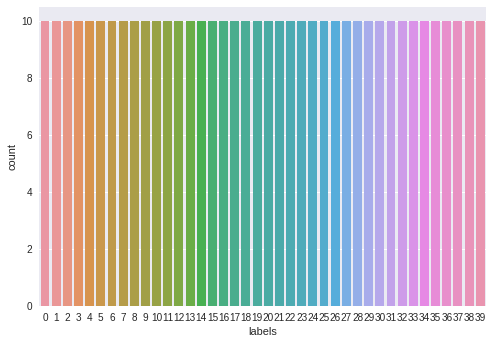

In [7]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame()
df["labels"]=target
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)


** show the  40 distinct people in the dataset**

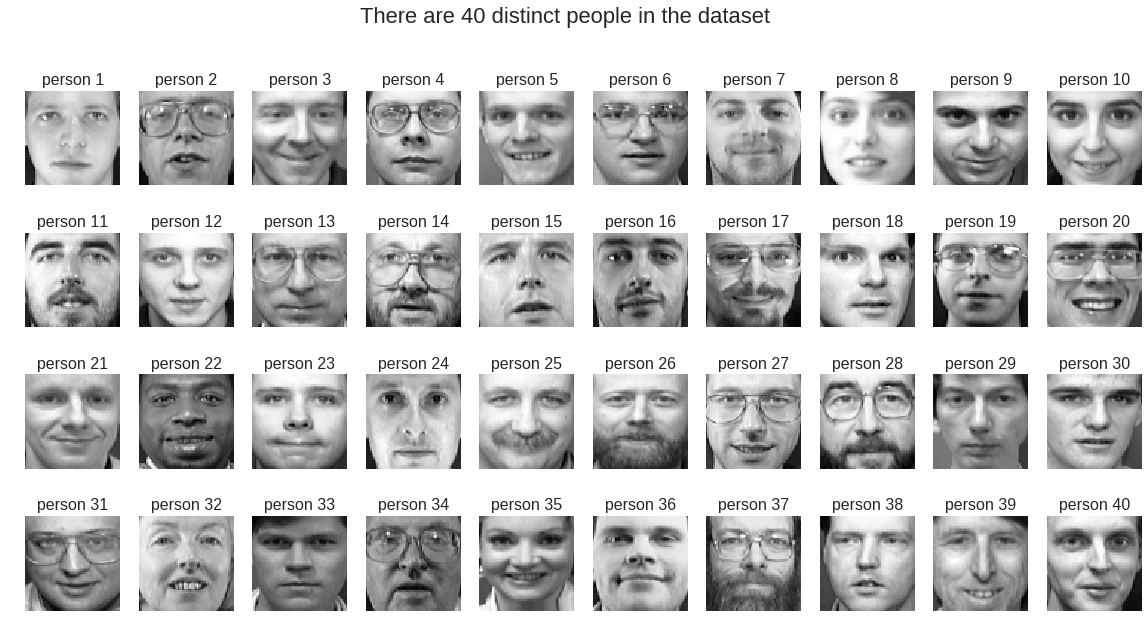

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
columns = 10
rows = 4
for i in range(1, columns*rows +1):
    img = img_array[10*(i-1),:,:]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    plt.title("person {}".format(i), fontsize=16)
    plt.axis('off')
    
plt.suptitle("There are 40 distinct people in the dataset", fontsize=22)
plt.show()

# Step 1: Extract Bottleneck Features for Train set, valid set, Test Set.





In [15]:
if os.path.exists('/content/bottleneck_features1.npz'):
    print('bottleneck features detected ')
else:
  from keras.applications.inception_v3 import InceptionV3, preprocess_input

  from keras.layers import Input



  basemodel1 = InceptionV3(weights='imagenet', include_top=False)
  img_input = preprocess_input(X_train)
  train=basemodel1.predict(img_input)
  print(train.shape)
  img_input = preprocess_input(X_test)
  test=basemodel1.predict(img_input)
  print(test.shape)
  img_input = preprocess_input(X_val)
  val=basemodel1.predict(img_input)
  print(val.shape)
  np.savez('bottleneck_features1',train=train,test=test,val=val)   

(240, 8, 8, 2048)
(80, 8, 8, 2048)
(80, 8, 8, 2048)


In [0]:

train_InceptionV3 = np.load('/content/bottleneck_features1.npz')['train']
valid_InceptionV3 = np.load('/content/bottleneck_features1.npz')['val']
test_InceptionV3 = np.load('/content/bottleneck_features1.npz')['test']


# Step 3: create Model Architecture

In [19]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


inception_v3_model = Sequential()
inception_v3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
inception_v3_model.add(Dense(180, activation='relu'))
inception_v3_model.add(Dropout(0.3))
inception_v3_model.add(Dense(40, activation='softmax'))

inception_v3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 180)               368820    
_________________________________________________________________
dropout_2 (Dropout)          (None, 180)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 40)                7240      
Total params: 376,060
Trainable params: 376,060
Non-trainable params: 0
_________________________________________________________________


In [0]:
inception_v3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

**Data augmentation**

In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:353: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


# Step 4: Train the Model

In [22]:

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=0.00000000001)
checkpointer= ModelCheckpoint(filepath='5.hdf5', verbose=1, save_best_only=True)
batch_size=20
history =inception_v3_model.fit_generator(datagen.flow(train_InceptionV3, train_hot, batch_size=batch_size), validation_data=(valid_InceptionV3, valid_hot),
          epochs=20, callbacks=[learning_rate_reduction], verbose=1, steps_per_epoch=train_InceptionV3.shape[0] // batch_size, shuffle=[False])


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (240, 8, 8, 2048) (2048 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/20
12/12 [==============================] - 10s 874ms/step - loss: 2.8726 - acc: 0.2625 - val_loss: 3.1355 - val_acc: 0.2250
Epoch 2/20
12/12 [==============================] - 10s 864ms/step - loss: 2.3894 - acc: 0.3417 - val_loss: 2.9299 - val_acc: 0.4125
Epoch 3/20
12/12 [==============================] - 10s 870ms/step - loss: 2.0148 - acc: 0.4542 - val_loss: 2.7084 - val_acc: 0.5250
Epoch 4/20
12/12 [==============================] - 10s 867ms/step - loss: 1.5580 - acc: 0.6333 - val_loss: 2.5516 - val_acc: 0.5750
Epoch 5/20
12/12 [==============================] - 10s 859ms/step - loss: 1.3836 - acc: 0.6708 - val_loss: 2.4042 - val_acc: 0.6625
Epoch 6/20
12/12 [==============================] - 10s 859ms/step - loss: 1.0235 - acc: 0.7417 - val_loss: 2.2686 - val_acc: 0.6875
Epoch 7/20
12/12 [==============================] - 10s 869ms/step - loss: 0.9691 - acc: 0.7833 - val_loss: 2.1403 - val_acc: 0.7125
Epoch 8/20
12/12 [==============================] - 10s 871ms/step - 

# Step 5: Test the Model

In [23]:
#inception_v3_model.load_weights('/content/5.hdf5')
inception_v3_predictions = [np.argmax(inception_v3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

test_accuracy_inception_v3 = 100*np.sum(np.array(inception_v3_predictions)==np.argmax(test_hot, axis=1))/len(inception_v3_predictions)
print('Final test accuracy: %.4f%%' % test_accuracy_inception_v3)

Final test accuracy: 96.2500%


# Step 6: plot learning curve

In [0]:
import matplotlib.pyplot as plt


def plot_confusion_matrix(x, inception_v3_predictions,classes= np.unique(target),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(x, inception_v3_predictions)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(x, inception_v3_predictions)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    

    fig, ax = plt.subplots()
    plt.figure(figsize = (5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

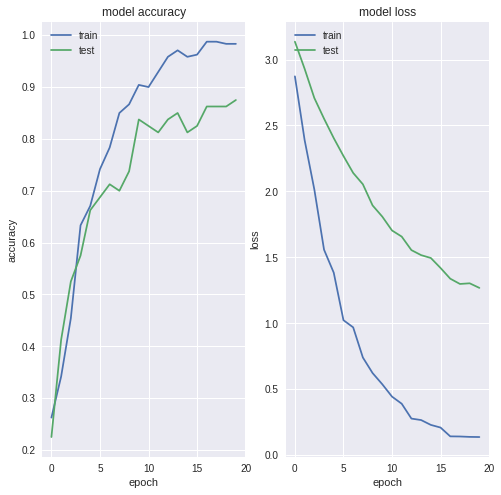

In [25]:
from sklearn.metrics import confusion_matrix

plot_learning_curve(history)

plt.show()
